# Testing Dense Correspondence

In [1]:
import numpy as np
np.set_printoptions(precision=4, threshold=10)

import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline

## Common Funcs

In [2]:
## Loading images with integer value intensities, range(0-255)
def load_rgb(path):
    img = cv.imread(path)
    img = img[..., ::-1]
    return img

def load_gray(path):
    img = cv.imread(path, 0)
    return img

In [3]:
def plot_rgb(img, figsize=None, title=None, xlabel=None, ylabel=None, interpolation=None, save=False):
    fig = plt.figure(num=None, figsize=figsize, dpi=100)
    
    if interpolation != None:
        plt.imshow(img, interpolation = interpolation)
    else:
        plt.imshow(img)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if save:        
        # plt.savefig(f'../imgs/{title}.png', dpi=100, bbox_inches=0) # shit method
        plt.imsave(f'../data/outs/{title}.png', img, cmap='gray')
        
    plt.show()
    plt.close(fig)

def plot_grayscale(img, figsize=None, title=None, xlabel=None, ylabel=None, save=False):
    fig = plt.figure(num=None, figsize=figsize, dpi=100)
    
    plt.imshow(img, cmap='gray')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if save:        
        # plt.savefig(f'../imgs/{title}.png', dpi=100, bbox_inches=0) # shit method
        plt.imsave(f'../data/outs/{title}.png', img, cmap='gray')
        
    plt.show()
    plt.close(fig)


## Test

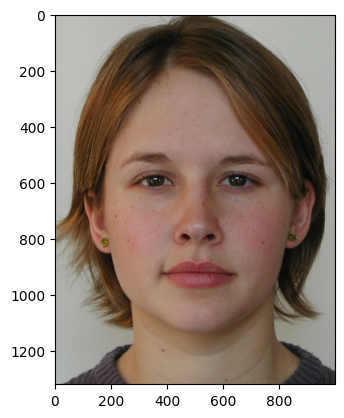

In [4]:
## Load Image

input_rgb = load_rgb('../data/inputs/input_1.png')
input_gray = load_gray('../data/inputs/input_1.png')

plot_rgb(input_rgb)
# plot_grayscale(input_gray)

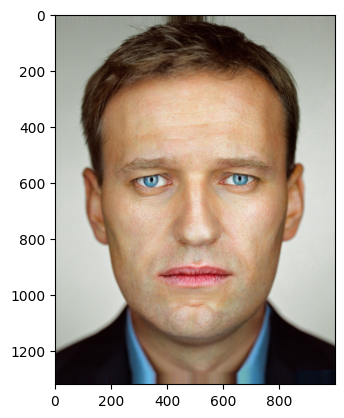

In [5]:
example_rgb = load_rgb('../data/inputs/example_1.png')
example_gray = load_gray('../data/inputs/example_1.png')

plot_rgb(example_rgb)

### SIFT Flow landmarks (for refining)

In [6]:
def sift_flow(img):
    img = np.copy(img)
    
    sift = cv.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    
    img_key = cv.drawKeypoints(img, kp, img)
    return img_key, kp

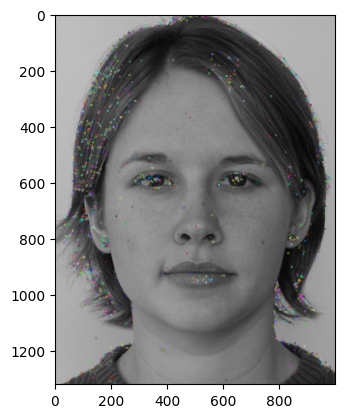

In [7]:
input_key, input_kp = sift_flow(input_gray)
# cv.imwrite('./src/sift_keypoints.png', img_key)

plot_rgb(input_key)

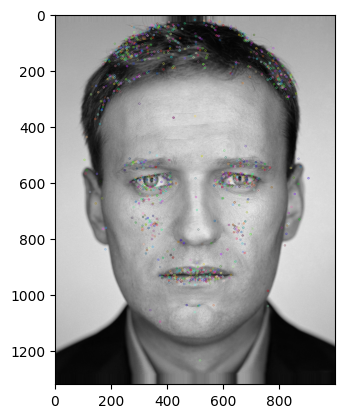

In [8]:
example_key, example_kp = sift_flow(example_gray)
plot_rgb(example_key)

### DLib Landmarks

In [9]:
import dlib
#http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
# !wget -nc http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

# face_detector = dlib.get_frontal_face_detector()
# landmark_detector = dlib.shape_predictor('../test_data/shape_predictor_68_face_landmarks.dat')

In [10]:
def face_landmarks(img):
    img = np.copy(img)
    
    face_detector = dlib.get_frontal_face_detector()
    landmark_detector = dlib.shape_predictor('../test_data/shape_predictor_68_face_landmarks.dat')
    
    # Asks the detector to fing the bounding boxes of each face
    # The 1 in the second argument indicates that we should upsample the image 1 time
    # This will make everything bigger and allow us to detect more faces
    
    total_faces = face_detector(img, 1)
    
    total_landmarks = []
    
    for k, face in enumerate(total_faces):
        landmarks = landmark_detector(img, face)
        
        for i in range(0, 68):
            x = landmarks.part(i).x
            y = landmarks.part(i).y

            total_landmarks.append([x, y])
            cv.circle(img, (x, y), 4, (255, 0, 0), -1)
            
    total_landmarks = np.array(total_landmarks)
    return img, total_landmarks

In [11]:
input_key, input_landmarks = face_landmarks(input_gray)

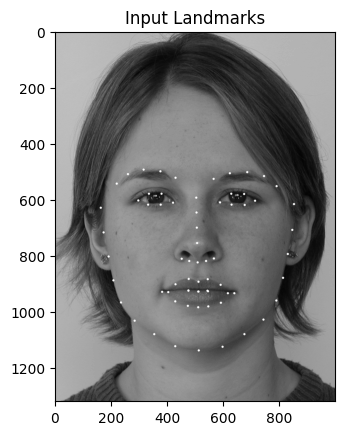

In [12]:
plot_grayscale(input_key, title='Input Landmarks')

In [13]:
example_key, example_landmarks = face_landmarks(example_gray)

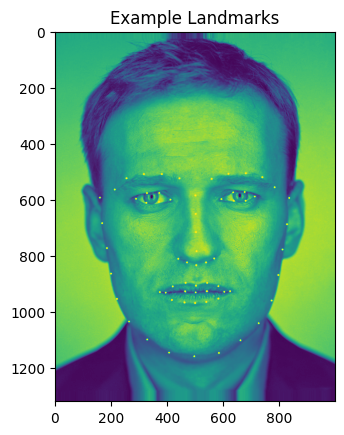

In [14]:
plot_rgb(example_key, title='Example Landmarks')

### Scipy Delaunay Triangulation

In [15]:
from scipy.spatial import Delaunay

In [16]:
def triangulation(img, img_landmarks):
    img = np.copy(img)
    
    tri = Delaunay(img_landmarks)
    triangles = img_landmarks[tri.simplices]
    
    for t in triangles:
        cv.line(img, t[0], t[1], (255, 255, 0), 2)
        cv.line(img, t[1], t[2], (255, 255, 0), 2)
        cv.line(img, t[2], t[0], (255, 255, 0), 2)
        
    return img, triangles

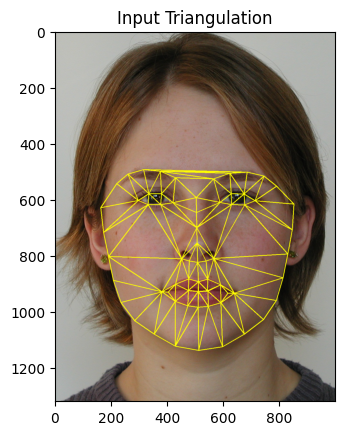

In [17]:
input_tri, input_triangles = triangulation(input_rgb, input_landmarks)
plot_rgb(input_tri, title='Input Triangulation')

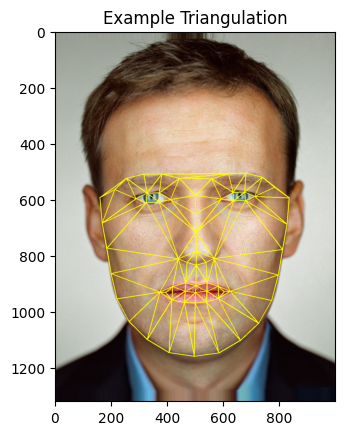

In [18]:
example_tri, example_triangles = triangulation(example_rgb, example_landmarks)
plot_rgb(example_tri, title='Example Triangulation')

### Affine Transform

In [19]:
# Check if a point is inside a rectangle
def rectContains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[0] + rect[2] :
        return False
    elif point[1] > rect[1] + rect[3] :
        return False
    return True

In [20]:
#calculate delanauy triangle
def calculateDelaunayTriangles(rect, points):
    #create subdiv
    subdiv = cv.Subdiv2D(rect);
    
    # Insert points into subdiv
    for p in points:
        # subdiv.insert(p)
        p = np.round(p)
        subdiv.insert([int(p[0]), int(p[1])])
    
    triangleList = subdiv.getTriangleList();
    
    delaunayTri = []
    
    pt = []    
        
    for t in triangleList:        
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))
        
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])        
        
        if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
            ind = []
            #Get face-points (from 68 face detector) by coordinates
            for j in range(0, 3):
                for k in range(0, len(points)):                    
                    if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
                        ind.append(k)    
            # Three points form a triangle. Triangle array corresponds to the file tri.txt in FaceMorph 
            if len(ind) == 3:                                                
                delaunayTri.append((ind[0], ind[1], ind[2]))
        
        pt = []
        
    return delaunayTri

In [21]:
# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size) :
    src = np.copy(src)
    
    # Given a pair of triangles, find the affine transform.
    warpMat = cv.getAffineTransform( np.float32(srcTri), np.float32(dstTri) )
    
    # Apply the Affine Transform just found to the src image
    dst = cv.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv.INTER_LINEAR, borderMode=cv.BORDER_REFLECT_101 )

    # return dst, warpMat
    return dst

In [22]:
# Warps and alpha blends triangular regions from img1 and img2 to img
def warpTriangle(img1, img2, t1, t2) :
    
    img1 = np.copy(img1)
    img2 = np.copy(img2)

    # Find bounding rectangle for each triangle
    r1 = cv.boundingRect(np.float32([t1]))
    r2 = cv.boundingRect(np.float32([t2]))

    # Offset points by left top corner of the respective rectangles
    t1Rect = [] 
    t2Rect = []
    t2RectInt = []

    for i in range(0, 3):
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))
        t2RectInt.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))


    # Get mask by filling triangle
    mask = np.zeros((r2[3], r2[2], 3), dtype = np.float32)
    cv.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0);

    # Apply warpImage to small rectangular patches
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    #img2Rect = np.zeros((r2[3], r2[2]), dtype = img1Rect.dtype)
    
    size = (r2[2], r2[3])

    img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)
    
    img2Rect = img2Rect * mask

    # Copy triangular region of the rectangular patch to the output image
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ( (1.0, 1.0, 1.0) - mask )
     
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect 
    
    return img2

In [23]:
def warpImage(img1, img2, points1, points2):
    img1 = np.copy(img1)
    img2 = np.copy(img2)
    
    img1Warped = np.copy(img2)
    
    # Find convex hull
    hull1 = []
    hull2 = []

    hullIndex = cv.convexHull(np.array(points2), returnPoints = False)
          
    for i in range(0, len(hullIndex)):
        hull1.append(points1[int(hullIndex[i])])
        hull2.append(points2[int(hullIndex[i])])
    
    
    # Find delanauy traingulation for convex hull points
    sizeImg2 = img2.shape    
    rect = (0, 0, sizeImg2[1], sizeImg2[0])
     
    dt = calculateDelaunayTriangles(rect, hull2)
    
    if len(dt) == 0:
        quit()
    
    # Apply affine transformation to Delaunay triangles
    for i in range(0, len(dt)):
        t1 = []
        t2 = []
        
        #get points for img1, img2 corresponding to the triangles
        for j in range(0, 3):
            t1.append(hull1[dt[i][j]])
            t2.append(hull2[dt[i][j]])
        
        img1Warped = warpTriangle(img1, img1Warped, t1, t2)
    
            
    # Calculate Mask
    hull8U = []
    for i in range(0, len(hull2)):
        hull8U.append((hull2[i][0], hull2[i][1]))
    
    mask = np.zeros(img2.shape, dtype = img2.dtype)
    
    cv.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))
    
    r = cv.boundingRect(np.float32([hull2]))
    
    center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))
        
    
    # Clone seamlessly.
    output = cv.seamlessClone(np.uint8(img1Warped), img2, mask, center, cv.NORMAL_CLONE)
    # output = cv.seamlessClone(np.uint8(img1Warped), img1, mask, center, cv.NORMAL_CLONE)
    
    return output

In [24]:
# output = warpImage(example_rgb, input_rgb, example_landmarks, input_landmarks)
output = warpImage(input_rgb, example_rgb, input_landmarks, example_landmarks)

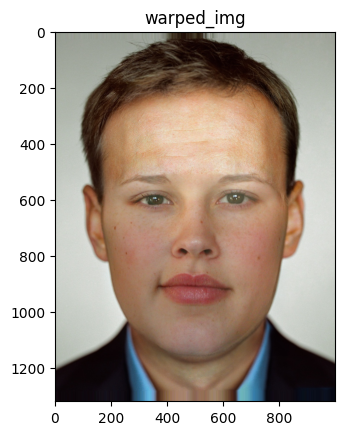

In [25]:
plot_rgb(output, title='warped_img', save=True)